In [1]:
import os
import re
from glob import glob
from importlib import reload

from collections import OrderedDict

import numpy as np

from astropy import units as u
from astropy import coordinates
from astropy.coordinates import SkyCoord, UnitSphericalRepresentation
from astropy import table
from astropy.visualization import hist as ahist

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# a fun trick that makes the notebook always be 95% of the browser window
from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

In [4]:
import data_loaders

#m31 = SkyCoord.from_name('M31')
m31 = SkyCoord(10.6847083*u.deg, 41.26875*u.deg, 700*u.kpc)

In [5]:
def coo_to_scatter_inputs(coo):
    x = coo.spherical.lon.wrap_at(180*u.deg).rad
    y = coo.spherical.lat.rad
    return np.atleast_1d(x), np.atleast_1d(y)

## Map out where Everything is is in the LSR frame 

In [6]:
n = 1000
lat = np.arcsin(2*np.random.rand(n)-1)*u.radian
lon  = np.random.rand(n)*360*u.deg

usr = UnitSphericalRepresentation(lat=lat, lon=lon)
cart = usr.to_cartesian()

In [7]:
#  map out a grid on the sphere
ntopring = 4
nlats = 21

ringlats = np.linspace(-90, 90, nlats+2)[1:-1]*u.deg
eqnum = ntopring/np.cos(ringlats[0])

lats = []
lons = []
for l in ringlats.to(u.deg):
    n = int(np.round(eqnum*np.cos(l)))
    lons.extend(np.linspace(0, 360, n, False))
    lats.extend([l.value]*n)
    
    
# velocities in the LSR converted to a galactic-fixed frame
vrot = 220*u.km/u.s

sc = SkyCoord(l=lons*u.deg, b=lats*u.deg, frame='galactic')
vr = -sc.cartesian.y*vrot

lsrrotdir = SkyCoord(l=90*u.deg, b=0*u.deg, frame='galactic')
lsrantirotdir = SkyCoord(l=270*u.deg, b=0*u.deg, frame='galactic')

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


([], <a list of 0 Text xticklabel objects>)

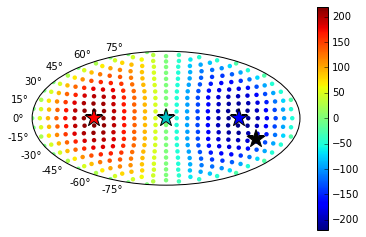

In [8]:
ax = plt.subplot(projection='hammer')
scat = ax.scatter(*coo_to_scatter_inputs(sc), c=vr, lw=0)
plt.colorbar(scat)

ax.scatter(*coo_to_scatter_inputs(m31.galactic), c='k', marker='*', s=350)
ax.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.galactic), c='c', marker='*', s=350)
ax.scatter(*coo_to_scatter_inputs(lsrrotdir.galactic), c='b', marker='*', s=350)
ax.scatter(*coo_to_scatter_inputs(lsrantirotdir.galactic), c='r', marker='*', s=350)

plt.xticks([])

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


([], <a list of 0 Text xticklabel objects>)

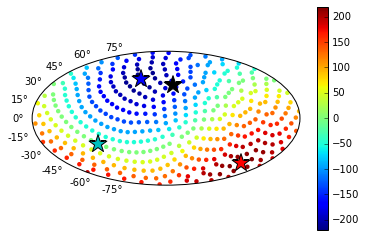

In [9]:
ax = plt.subplot(projection='hammer')
scat = ax.scatter(*coo_to_scatter_inputs(sc.icrs), c=vr, lw=0)
plt.colorbar(scat)

ax.scatter(*coo_to_scatter_inputs(m31.icrs), c='k', marker='*', s=350)
ax.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), c='c', marker='*', s=350)
ax.scatter(*coo_to_scatter_inputs(lsrrotdir.icrs), c='b', marker='*', s=350)
ax.scatter(*coo_to_scatter_inputs(lsrantirotdir.icrs), c='r', marker='*', s=350)

plt.xticks([])

# ELVIS- dependent tests on LSR effects and roll 

In [12]:
elvii_pairs = data_loaders.load_elvii(isolated=False)

Loading /Users/erik/projects/m31-galfa/elvis_data/Burr&Hamilton.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Charybdis&Scylla.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Cher&Sonny.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Hall&Oates.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Kauket&Kek.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Lincoln&Douglas.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Romulus&Remus.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Siegfried&Roy.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Taurus&Orion.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Thelma&Louise.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Venus&Serana.txt
Loading /Users/erik/projects/m31-galfa/elvis_data/Zeus&Hera.txt


## Single pair 

In [13]:
nroll = 10

newtabs = OrderedDict()
for tab in elvii_pairs.values():
    for roll in np.linspace(0, 360, nroll, False)*u.deg:
        newtabs[roll] = newtab = tab.copy()
        data_loaders.add_oriented_radecs(newtab, 0, 1, target_coord=m31, roll_angle=roll)
        data_loaders.add_oriented_radecs(newtab, 1, 0, target_coord=m31, roll_angle=roll)
    break

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/astropy/units/quantity.py:763: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return super(Quantity, self).__eq__(other)


In [14]:
sc0 = SkyCoord(newtab['host0_lon'],newtab['host0_lat'],distance=newtab['host0_dist'])
sc1 = SkyCoord(newtab['host1_lon'],newtab['host1_lat'],distance=newtab['host1_dist'])

#these should all be the same for the assumptions to hold right
data_loaders.galactic_center.separation(m31), sc0[0].separation(sc0[1]), sc1[0].separation(sc1[1])

(<Angle 118.77568035668436 deg>,
 <Angle 118.77568035668436 deg>,
 <Angle 118.77568035668438 deg>)

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


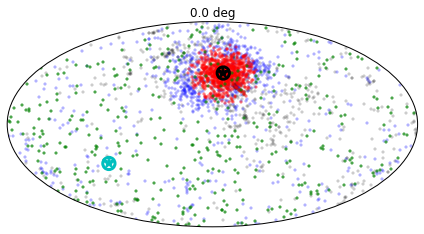

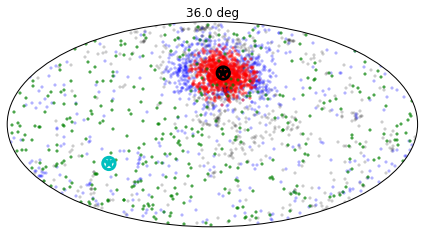

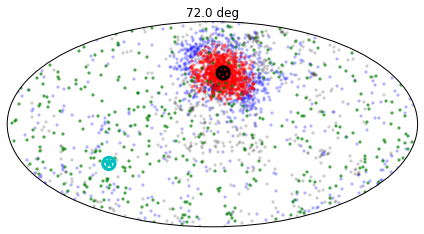

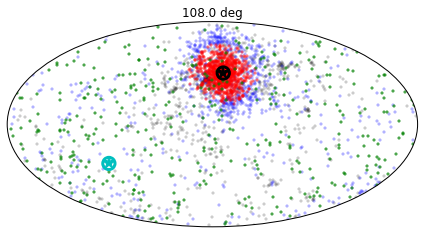

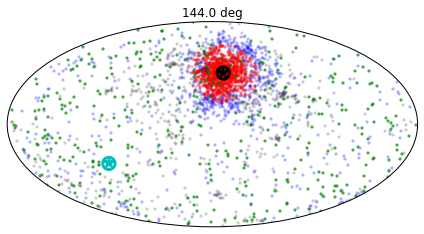

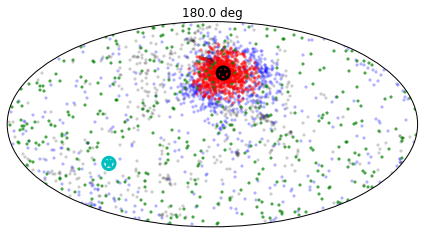

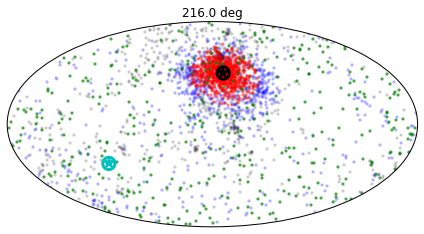

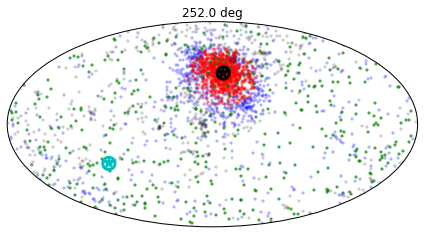

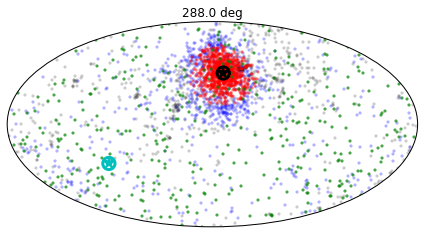

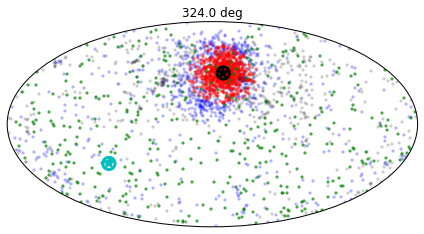

In [15]:
for roll, newtab in newtabs.items():
    sc0 = SkyCoord(newtab['host0_lon'],newtab['host0_lat'],distance=newtab['host0_dist'])
    sc1 = SkyCoord(newtab['host1_lon'],newtab['host1_lat'],distance=newtab['host1_dist'])
    near1 = newtab['host1_dist']<newtab['Rvir'][1]
    near0 = newtab['host0_dist']<newtab['Rvir'][0]
    nearish = (newtab['host0_dist']<.7*u.Mpc)|(newtab['host1_dist']<.7*u.Mpc)

    plt.figure()
    plt.subplot(projection='hammer')
    
    msk0 = ~(near1|near0|nearish)
    msk2 = near1
    msk3 = near0
    msk1 = ~(msk0|msk2|msk3)

    plt.scatter(*coo_to_scatter_inputs(sc0[msk0]), c='k',s=10, alpha=.2, lw=0)
    plt.scatter(*coo_to_scatter_inputs(sc0[msk1]), c='b',s=10, alpha=.3, lw=0)
    plt.scatter(*coo_to_scatter_inputs(sc0[msk2]), c='r',s=10, alpha=.5, lw=0)
    plt.scatter(*coo_to_scatter_inputs(sc0[msk3]), c='g',s=10, alpha=.7, lw=0)

    plt.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), color='c', marker='*', s=150)
    plt.scatter(*coo_to_scatter_inputs(m31.icrs), color='k', marker='*', s=150)


    plt.scatter(*coo_to_scatter_inputs(sc0[0]), edgecolors='c', marker='o', s=150, lw=3, c='none')
    plt.scatter(*coo_to_scatter_inputs(sc0[1]), edgecolors='k', marker='o', s=150, lw=3, c='none')

    plt.xticks([])
    plt.yticks([])
    plt.title(str(roll))
    plt.tight_layout()

## Look at gal_vsr velocities

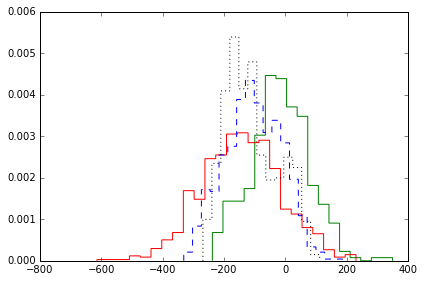

In [16]:
bins='freedman'
ahist(newtab['host0_galvr'][near0], histtype='step', bins=bins, color='g', normed=True)
ahist(newtab['host0_galvr'][near1], histtype='step', bins=bins, color='r', normed=True)
ahist(newtab['host0_galvr'][nearish&~(near0|near1)], histtype='step', bins=bins, color='b', normed=True, ls='--')
ahist(newtab['host0_galvr'][~(near1|near0|nearish)], histtype='step', bins=bins, color='k', normed=True, ls=':')
plt.tight_layout()

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


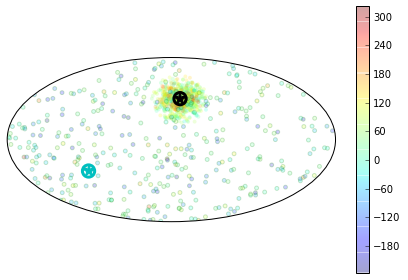

In [17]:
newtab = newtabs[0*u.deg]

sc0 = SkyCoord(newtab['host0_lon'],newtab['host0_lat'],distance=newtab['host0_dist'])
sc1 = SkyCoord(newtab['host1_lon'],newtab['host1_lat'],distance=newtab['host1_dist'])
near1 = newtab['host1_dist']<newtab['Rvir'][1]
near0 = newtab['host0_dist']<newtab['Rvir'][0]
nearish = (newtab['host0_dist']<.7*u.Mpc)|(newtab['host1_dist']<.7*u.Mpc)

plt.figure()
plt.subplot(projection='hammer')

plt.scatter(*coo_to_scatter_inputs(sc0[near1]), c=newtab['host0_galvr'][near1], s=15, alpha=.2, lw=1, edgecolor='')
plt.scatter(*coo_to_scatter_inputs(sc0[near0]), c=newtab['host0_galvr'][near0], s=15, alpha=.2, lw=1, edgecolor='g')
plt.colorbar()

plt.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), color='c', marker='*', s=150)
plt.scatter(*coo_to_scatter_inputs(m31.icrs), color='k', marker='*', s=150)


plt.scatter(*coo_to_scatter_inputs(sc0[0]), edgecolors='c', marker='o', s=150, lw=3, c='none')
plt.scatter(*coo_to_scatter_inputs(sc0[1]), edgecolors='k', marker='o', s=150, lw=3, c='none')

plt.xticks([])
plt.yticks([])
plt.tight_layout()

 ## And vrlsr

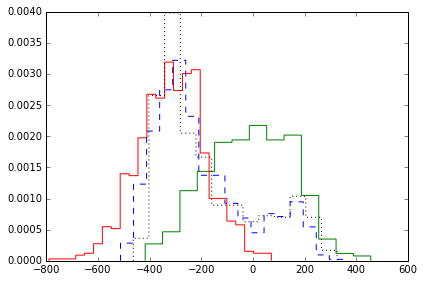

In [18]:
bins='freedman'
ahist(newtab['host0_vrlsr'][near0], histtype='step', bins=bins, color='g', normed=True)
ahist(newtab['host0_vrlsr'][near1], histtype='step', bins=bins, color='r', normed=True)
ahist(newtab['host0_vrlsr'][nearish&~(near0|near1)], histtype='step', bins=bins, color='b', normed=True, ls='--')
ahist(newtab['host0_vrlsr'][~(near1|near0|nearish)], histtype='step', bins=bins, color='k', normed=True, ls=':')
plt.tight_layout()

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/matplotlib/projections/geo.py:394: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1.0 - quarter_x*quarter_x - half_y*half_y)


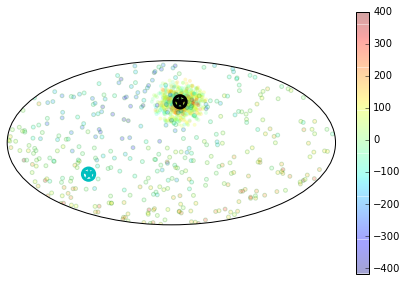

In [19]:
newtab = newtabs[0*u.deg]

sc0 = SkyCoord(newtab['host0_lon'],newtab['host0_lat'],distance=newtab['host0_dist'])
sc1 = SkyCoord(newtab['host1_lon'],newtab['host1_lat'],distance=newtab['host1_dist'])
near1 = newtab['host1_dist']<newtab['Rvir'][1]
near0 = newtab['host0_dist']<newtab['Rvir'][0]
nearish = (newtab['host0_dist']<.7*u.Mpc)|(newtab['host1_dist']<.7*u.Mpc)

plt.figure()
plt.subplot(projection='hammer')

plt.scatter(*coo_to_scatter_inputs(sc0[near1]), c=newtab['host0_vrlsr'][near1], s=15, alpha=.2, lw=1, edgecolor='')
plt.scatter(*coo_to_scatter_inputs(sc0[near0]), c=newtab['host0_vrlsr'][near0], s=15, alpha=.2, lw=1, edgecolor='g')
plt.colorbar()

plt.scatter(*coo_to_scatter_inputs(data_loaders.galactic_center.icrs), color='c', marker='*', s=150)
plt.scatter(*coo_to_scatter_inputs(m31.icrs), color='k', marker='*', s=150)


plt.scatter(*coo_to_scatter_inputs(sc0[0]), edgecolors='c', marker='o', s=150, lw=3, c='none')
plt.scatter(*coo_to_scatter_inputs(sc0[1]), edgecolors='k', marker='o', s=150, lw=3, c='none')

plt.xticks([])
plt.yticks([])
plt.tight_layout()